In [196]:
import csv
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [197]:
df = pd.read_csv("C:/Users/Amy Le - PC/Documents/WA_Fn-UseC_-Telco-Customer-Churn.csv", low_memory = False)
df = df.replace(" ", np.NaN)
###The telecom dataset is collected from IBM Watson Analytics "https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/"


In [198]:
print(df.shape)
top = df.head(5)
print(top)
### The dataset has 21 attributes and 7043 instances(customers)
### Churn (yes, no) is the target feature

(7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  DeviceProtection  \
0  No phone service             DSL             No  ...                No   
1                No             DSL            Yes  ...               Yes   
2                No             DSL            Yes  ...                No   
3  No phone service             DSL            Yes  ...               Yes   
4                No     Fiber optic             No  ...                No   

  TechSupport StreamingTV StreamingMovies    

Data Preprocessing


In [199]:
df.isnull().sum()
### Checking missing values-> there are 11 missing values in “TotalCharges” column.

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [200]:
df.dropna(inplace=True) #remove all rows with missing values

In [201]:
### I assume that "No internet service" value is the same as "No" value for the following attributes: MultipleLines; 
#OnlineSecurity; OnlineBackup; DeviceProtection; TechSupport; StreamingTV; StreamingMovies
### "No phone service" value is the same as "No" value for "MultipleLine" attribute

df.replace("No internet service", "No", inplace = True)
df.replace("No phone service", "No", inplace = True)

### Change the value for 'SeniorCitizen' attribute
replacements = {
  1: 'Yes',
  0: 'No'
}
df['SeniorCitizen'].replace(replacements, inplace=True)
Y = df['Churn']
X = df.drop(['customerID'], axis =1)

types = X.dtypes

X['TotalCharges'] = X['TotalCharges'].apply(pd.to_numeric) # Convert to numeric type
###Creating a list of categorical features
cat_col = X.select_dtypes(exclude=[np.number]).columns.tolist()

### For every column, if categorical, convert to label encoding
for i in X.columns:
    if i in cat_col:
        X[i] = X[i].astype('category').cat.codes
X.head()



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


Model Building

In [202]:
#Correlation Between attributes
correlations = X.corr(method='pearson')
print(correlations)
### As we can see, 'TotalCharges' are correlated with both 'tenure' and 'MonthlyCharges', so I remove this attribute 
#from the model.

                    gender  SeniorCitizen   Partner  Dependents    tenure  \
gender            1.000000      -0.001819 -0.001379    0.010349  0.005285   
SeniorCitizen    -0.001819       1.000000  0.016957   -0.210550  0.015683   
Partner          -0.001379       0.016957  1.000000    0.452269  0.381912   
Dependents        0.010349      -0.210550  0.452269    1.000000  0.163386   
tenure            0.005285       0.015683  0.381912    0.163386  1.000000   
PhoneService     -0.007515       0.008392  0.018397   -0.001078  0.007877   
MultipleLines    -0.008883       0.142996  0.142561   -0.024307  0.332399   
InternetService  -0.002236      -0.032160  0.000513    0.044030 -0.029835   
OnlineSecurity   -0.016328      -0.038576  0.143346    0.080786  0.328297   
OnlineBackup     -0.013093       0.066663  0.141849    0.023639  0.361138   
DeviceProtection -0.000807       0.059514  0.153556    0.013900  0.361520   
TechSupport      -0.008507      -0.060577  0.120206    0.063053  0.325288   

In [203]:
X.drop(['TotalCharges'], axis =1, inplace = True)

In [204]:
#Class distribution
class_counts = X.groupby('Churn').size()
print(class_counts)

#Outcome of this dataset is a majority of 'Churn ==0 (no)' class. Therefore, F1 score is more useful than accuracy score 
#as a metric for model evaluation. 

Churn
0    5163
1    1869
dtype: int64


In [205]:
X.drop(['Churn'], axis =1, inplace = True)

Model Building

Some supervised learning methods such as Logistics Regression, Random Tree, SVM, AdaBoost are applied to find the best model.


In [206]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, Y, X.index, test_size=0.3, random_state=0)



In [207]:
# Suport Vector Machine classifier
model1 = LinearSVC()
# Train the supervised model on the training set using .fit(X_train, y_train)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test) #predicted class
print(metrics.classification_report(y_test, y_pred1))

### F1 score is 66%

             precision    recall  f1-score   support

         No       0.93      0.56      0.70      1555
        Yes       0.42      0.88      0.57       555

avg / total       0.80      0.64      0.66      2110



In [208]:
#Random Forest classifier

model2 = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# Train the supervised model on the training set using .fit(X_train, y_train)
model2 = model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(metrics.classification_report(y_test, y_pred2))

### F1 score is 77%


             precision    recall  f1-score   support

         No       0.82      0.90      0.86      1555
        Yes       0.62      0.46      0.53       555

avg / total       0.77      0.78      0.77      2110



In [209]:
###RandomForest Parameter Tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 5000, num = 15)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 100, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


from sklearn.model_selection import RandomizedSearchCV

# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=3, random_state=1, n_jobs = -1)

rf_random.fit(X_train, y_train)

rf_best = rf_random.best_estimator_

y_pred = rf_best.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

### F1 score: 79%



{'n_estimators': [10, 366, 722, 1079, 1435, 1792, 2148, 2505, 2861, 3217, 3574, 3930, 4287, 4643, 5000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 12, 23, 34, 45, 56, 67, 78, 89, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 18.3min finished


             precision    recall  f1-score   support

         No       0.83      0.91      0.87      1555
        Yes       0.66      0.49      0.56       555

avg / total       0.79      0.80      0.79      2110



In [228]:
# Extract the feature importances using .feature_importances_ 
importances = rf_best.feature_importances_
print(X_train.columns)
print(importances)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges'],
      dtype='object')
[ 0.02230367  0.02361511  0.01825075  0.01741022  0.25509525  0.00701686
  0.01904451  0.06157091  0.02808663  0.02025751  0.01462978  0.02720368
  0.01609191  0.01783702  0.16698892  0.03717886  0.06057417  0.18684424]


Feature ranking:
1. feature 4 (0.255095)
2. feature 17 (0.186844)
3. feature 14 (0.166989)
4. feature 7 (0.061571)
5. feature 16 (0.060574)
6. feature 15 (0.037179)
7. feature 8 (0.028087)
8. feature 11 (0.027204)
9. feature 1 (0.023615)
10. feature 0 (0.022304)
11. feature 9 (0.020258)
12. feature 6 (0.019045)
13. feature 2 (0.018251)
14. feature 13 (0.017837)
15. feature 3 (0.017410)
16. feature 12 (0.016092)
17. feature 10 (0.014630)
18. feature 5 (0.007017)


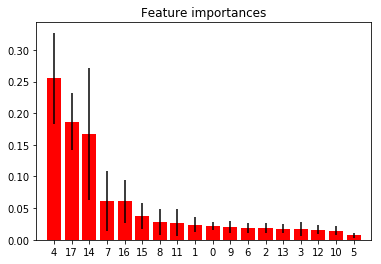

In [227]:
# Print the feature ranking
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

From the graph, we learn that the 'MonthlyCharges', 'tenure','Contract', and 'Payment Method'  are the key features that has the most importance on the whether or not customers will leave.

In [219]:
#Logistic Regression
from sklearn.feature_selection import RFE
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print(logreg.coef_)
y_pred3 = logreg.predict(X_test)
logreg.score(X_test, y_test) 
print(metrics.classification_report(y_test, y_pred3))

###F1 score: 79%

[[ 0.02175347  0.35319102  0.09135119 -0.2558159  -0.03694314 -1.17115431
   0.16724972  0.03363861 -0.48523916 -0.35599761 -0.06627493 -0.54627685
  -0.05007318 -0.0099329  -0.70010775  0.47396135  0.06278018  0.03429433]]
             precision    recall  f1-score   support

         No       0.84      0.89      0.87      1555
        Yes       0.64      0.53      0.58       555

avg / total       0.79      0.80      0.79      2110



In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=1000,
                         learning_rate=2)

bdt.fit(X_train, y_train)
y_pred4 = bdt.predict(X_test)
y_pred_prob = bdt.predict_proba(X_test)
y_pred_prob = [i[1] for i in y_pred_prob]

print(metrics.classification_report(y_test, y_pred4))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(X,Y)

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())